# Random Masking Coverage Test


In [1]:
import numpy as np
from astropy.time import Time

def prepare_and_save_real_data_adjusted(
    data_path,
    save_file_path,
    keys=['X', 'NIR', 'IR', 'Sub-mm'],
    mask_eval_fraction=0.2
):
    """
    Prepares, standardizes, and masks a specified fraction of real observed data for evaluation.
    Saves all values in their standardized form.

    Args:
        data_path (str): Directory with raw data files.
        save_file_path (str): Base path to save output npz files.
        keys (list): Names of each channel.
        mask_eval_fraction (float): Fraction of observed data to mask per channel.
    """

    data_dict = {}
    eval_ground_truth = {}
    max_time = 0

    # Load raw data and align time axis
    for key in keys:
        if key == 'X':
            file = data_path + '0718chan.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'NIR':
            file = data_path + '0718grav.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'IR':
            file = data_path + '0718sptz.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 2] * 1e3
        elif key == 'Sub-mm':
            file = data_path + '0718alma.dat'
            df = np.genfromtxt(file, delimiter=' ')
            bmjd, flux = df[:, 2], df[:, 3]
        else:
            raise ValueError(f"Unknown key: {key}")

        time = Time(bmjd, format='mjd', scale='tcb').utc.to_datetime()
        start_time = min(time)
        minutes_since_start = np.array([(t - start_time).total_seconds() / 60 for t in time])

        data_dict[key] = {
            'time': minutes_since_start,
            'flux': flux
        }

        max_time = max(max_time, int(max(minutes_since_start)) + 1)

    # Build a standardized array with mask
    channels = len(keys)
    data = np.zeros((1, max_time, channels * 2 + 1))  # +1 for time channel

    for j, key in enumerate(keys):
        minutes = data_dict[key]['time'].astype(int)
        flux = data_dict[key]['flux']

        data[0, minutes, j] = flux
        data[0, minutes, channels + j] = 1  # Observed mask

    # Standardize each channel
    for j, key in enumerate(keys):
        channel_data = data[0, :, j]
        observed = data[0, :, channels + j] == 1
        if np.any(observed):
            mean = np.mean(channel_data[observed])
            std = np.std(channel_data[observed])
            std = std if std > 0 else 1.0  # Avoid division by zero
            data[0, :, j] = (channel_data - mean) / std

    # Mask a fraction of observed points for evaluation and store only them
    for j, key in enumerate(keys):
        observed_indices = np.where(data[0, :, channels + j] == 1)[0]
        num_to_mask = int(len(observed_indices) * mask_eval_fraction)
        if num_to_mask == 0:
            continue

        selected_indices = np.random.choice(observed_indices, num_to_mask, replace=False)

        # Store standardized times and flux values of masked points
        masked_times = selected_indices
        standardized_values = data[0, masked_times, j] # Already standardized

        eval_ground_truth[key] = {
            'times': masked_times,
            'values': standardized_values
        }

        # Mask them in the data
        data[0, masked_times, channels + j] = 0

    # Fill normalized time channel (e.g. for TripletFormer)
    data[0, :, -1] = np.linspace(0, 1, max_time)

    # Save full data
    np.savez(save_file_path, real_data=data)

    # Save MOGP version (without time channel)
    np.savez(save_file_path.replace('.npz', '_mogp.npz'), real_data=data[:, :, :-1])

    # Save only ground truth values and times for evaluation
    np.savez(save_file_path.replace('.npz', '_eval_ground_truth.npz'),
             **eval_ground_truth, allow_pickle=True)

    return data

In [2]:
import numpy as np
from scipy.stats import norm

def compute_coverage(lower, upper, gt_values):
    """
    Computes the proportion of ground truth values that fall within the given interval.
    """
    return np.mean((gt_values >= lower) & (gt_values <= upper))


def compute_coverage_at_percentage(mean_preds, std_preds, gt_values, coverage_percentage):
    sigma_multiplier = norm.ppf(1 - (1 - coverage_percentage) / 2)
    lower_bound = mean_preds - sigma_multiplier * std_preds
    upper_bound = mean_preds + sigma_multiplier * std_preds
    return np.mean((gt_values >= lower_bound) & (gt_values <= upper_bound))


def calculate_model_coverage_across_percentages(model_files, gt_file, keys, coverage_percentages):
    gt = np.load(gt_file, allow_pickle=True)
    coverage_results = {model_name: [] for model_name in model_files.keys()}

    for coverage in coverage_percentages:
        model_coverage_across_keys = {model_name: [] for model_name in model_files.keys()}

        for key in keys:
            if key not in gt:
                continue

            gt_item = gt[key].item()
            gt_times = gt_item['times']
            gt_values = gt_item['values']

            for model_name, file_path in model_files.items():
                model_data = np.load(file_path, allow_pickle=True)
                test_x = model_data[f"{key}_test_x"].squeeze()
                mean_preds = model_data[f"{key}_predicted_means"]
                upper_bound_95 = model_data[f"{key}_upper_bound"]
                lower_bound_95 = model_data[f"{key}_lower_bound"]

                sigma_multiplier_95 = norm.ppf(0.975)
                std_preds = (upper_bound_95 - lower_bound_95) / (2 * sigma_multiplier_95)

                idx_map = {int(t): idx for idx, t in enumerate(test_x)}
                matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
                matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

                if len(matched_pred_indices) > 0:
                    mean_preds_matched = mean_preds[matched_pred_indices]
                    std_preds_matched = std_preds[matched_pred_indices]
                    coverage_value = compute_coverage_at_percentage(mean_preds_matched,
                                                                    std_preds_matched,
                                                                    matched_gt_values,
                                                                    coverage)
                    model_coverage_across_keys[model_name].append(coverage_value)

        # average across wavelengths
        for model_name in model_files.keys():
            avg_coverage = np.nanmean(model_coverage_across_keys[model_name])
            coverage_results[model_name].append(avg_coverage)

    return coverage_results


def get_coverage_data(keys=["X", 'NIR', "IR", "Sub-mm"],
                      gaussian_file='../GPyTorch/coverage_test.npz',
                      tripletformer_file='../Tripletformer/coverage_test.npz',
                      diffusion_file='../Diffusion/coverage_test.npz',
                      gt_file='coverage_test_data_eval_ground_truth.npz'):

    """
    Calculates the coverage for each model and wavelength and returns the data
    necessary for plotting.

    Returns:
        dict: A dictionary containing the coverage data for each model and wavelength.
              The keys of the dictionary are the model names ('MOGP', 'TripletFormer', 'CSPD'),
              and the values are lists of coverage values corresponding to the order of the 'keys' list.
    """

    # Load prediction files
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    # Load ground truth of masked points
    gt = np.load(gt_file, allow_pickle=True)

    model_names = ['MOGP', 'TripletFormer', 'CSPD']
    all_coverage = {model: [] for model in model_names}

    for key in keys:
        coverage_per_wavelength = {model: np.nan for model in model_names}

        all_test_x = [
            gaussian_data[f"{key}_test_x"],
            tripletformer_data[f"{key}_test_x"],
            diffusion_data[f"{key}_test_x"]
        ]
        all_lowers = [
            gaussian_data[f"{key}_lower_bound"],
            tripletformer_data[f"{key}_lower_bound"],
            diffusion_data[f"{key}_lower_bound"]
        ]
        all_uppers = [
            gaussian_data[f"{key}_upper_bound"],
            tripletformer_data[f"{key}_upper_bound"],
            diffusion_data[f"{key}_upper_bound"]
        ]

        if key not in gt:
            print(f"[WARNING] Ground truth not found for wavelength: {key}")
            for model in model_names:
                all_coverage[model].append(np.nan)
            continue

        gt_item = gt[key].item()
        gt_times = gt_item['times']
        gt_values = gt_item['values']

        for i, model_name in enumerate(model_names):
            test_x = np.array(all_test_x[i]).squeeze()
            lower_bound = np.array(all_lowers[i])
            upper_bound = np.array(all_uppers[i])
            index_in_pred = {int(t): idx for idx, t in enumerate(test_x)}

            matched_pred_indices = []
            matched_gt_values = []

            for j, t in enumerate(gt_times):
                t = int(t)
                if t in index_in_pred:
                    matched_pred_indices.append(index_in_pred[t])
                    matched_gt_values.append(gt_values[j])

            matched_pred_indices = np.array(matched_pred_indices)
            matched_gt_values = np.array(matched_gt_values)

            if len(matched_pred_indices) > 0:
                lower = lower_bound[matched_pred_indices]
                upper = upper_bound[matched_pred_indices]
                coverage = compute_coverage(lower, upper, matched_gt_values)
                coverage_per_wavelength[model_name] = coverage
            else:
                print(f"[WARNING] No matching indices for {key} in model {model_name}")

        for model in model_names:
            all_coverage[model].append(coverage_per_wavelength[model])

    return all_coverage

def save_plot_data(filename, coverage_data, keys):
    """
    Saves the coverage data and wavelength keys to a .npz file.

    Args:
        filename (str): The name of the file to save the data to.
        coverage_data (dict): The dictionary containing coverage data per model.
        keys (list): The list of wavelength keys.
    """
    np.savez(filename, coverage_data=coverage_data, keys=keys)
    print(f"Plot data saved to {filename}")


def compute_mse_per_model(model_outputs, gt_file, keys):
    gt = np.load(gt_file, allow_pickle=True)
    mse_results = {model: {} for model in model_outputs}

    for model_name, model_path in model_outputs.items():
        model_data = np.load(model_path, allow_pickle=True)

        for key in keys:
            if key not in gt:
                mse_results[model_name][key] = np.nan
                continue

            gt_item = gt[key].item()
            gt_times = gt_item['times']
            gt_values = gt_item['values']

            test_x = model_data[f"{key}_test_x"].squeeze()
            mean_preds = model_data[f"{key}_predicted_means"]

            idx_map = {int(t): idx for idx, t in enumerate(test_x)}
            matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
            matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

            if matched_pred_indices:
                mean_matched = mean_preds[matched_pred_indices]
                mse = np.mean((np.array(matched_gt_values) - mean_matched) ** 2)
            else:
                mse = np.nan

            mse_results[model_name][key] = mse

    return mse_results

In [ ]:
import numpy as np
import os
import subprocess
from scipy.stats import norm

def run_notebook_in_pipenv(notebook_path, python_interpreter, args=None):
    env = os.environ.copy()
    env["PIPENV_IGNORE_VIRTUALENVS"] = "1"
    command = ["pipenv", "--python", python_interpreter, "run", "ipython", notebook_path]
    if args:
        command.extend(args)
    try:
        subprocess.run(command, check=True, env=env)
    except subprocess.CalledProcessError as e:
        print(f"Error running {notebook_path}: {e}")

if __name__ == "__main__":
    seed_values = np.arange(4, 26)
    data_path = '../../Data/'
    save_file_path = 'coverage_test_data.npz'
    keys = ["X", 'NIR', "IR", "Sub-mm"]
    mask_eval_fraction = 0.2
    original_cwd = os.getcwd()
    print(original_cwd)

    coverage_percentages = np.linspace(0.1, 0.99, 10)

    gpytorch_python = '/home/gsasseville/.local/share/virtualenvs/GPyTorch-L0I7ISKI/bin/python'
    tripletformer_python = '/home/gsasseville/.local/share/virtualenvs/Tripletformer-nUF7tw2u/bin/python'
    diffusion_python = '/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/bin/python'

    for seed in seed_values:
        print('--------------------Seed Number: ', seed, '--------------------')
        np.random.seed(seed)
        prepare_and_save_real_data_adjusted(data_path, save_file_path, keys, mask_eval_fraction)

        model_dirs = {
            'MOGP': ('../GPyTorch', gpytorch_python),
            'TripletFormer': ('../Tripletformer', tripletformer_python),
            'Diffusion': ('../Diffusion', diffusion_python)
        }

        model_outputs = {}

        for model_name, (model_dir, interpreter) in model_dirs.items():
            os.chdir(model_dir)
            print(f"Running {model_name} notebook in: {os.getcwd()} using interpreter: {interpreter}")
            run_notebook_in_pipenv('coverage_test.ipynb', interpreter, args=[
                'output_file=coverage_test.npz',
                f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
            model_outputs[model_name] = os.path.join(os.getcwd(), 'coverage_test.npz')
            os.chdir(original_cwd)

        gt_file = os.path.join(original_cwd, 'coverage_test_data_eval_ground_truth.npz')

        # Compute 95% coverage per wavelength
        plot_data = get_coverage_data(keys, model_outputs['MOGP'], model_outputs['TripletFormer'], model_outputs['Diffusion'], gt_file)
        save_plot_data(f'coverage_plot_data_{seed}.npz', plot_data, keys)

        # Compute calibration curve
        for model_name in model_outputs:
            calibration_per_percentage = []

            for coverage in coverage_percentages:
                wavelength_coverages = []

                for key in keys:
                    gt = np.load(gt_file, allow_pickle=True)
                    if key not in gt:
                        continue

                    gt_item = gt[key].item()
                    gt_times = gt_item['times']
                    gt_values = gt_item['values']

                    model_data = np.load(model_outputs[model_name], allow_pickle=True)
                    test_x = model_data[f"{key}_test_x"].squeeze()
                    mean_preds = model_data[f"{key}_predicted_means"]
                    upper_95 = model_data[f"{key}_upper_bound"]
                    lower_95 = model_data[f"{key}_lower_bound"]
                    sigma_95 = norm.ppf(0.975)
                    std_preds = (upper_95 - lower_95) / (2 * sigma_95)

                    idx_map = {int(t): idx for idx, t in enumerate(test_x)}
                    matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
                    matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

                    if matched_pred_indices:
                        mean_matched = mean_preds[matched_pred_indices]
                        std_matched = std_preds[matched_pred_indices]
                        coverage_value = compute_coverage_at_percentage(mean_matched, std_matched, matched_gt_values, coverage)
                        wavelength_coverages.append(coverage_value)

                calibration_per_percentage.append(np.nanmean(wavelength_coverages))

            # Load per-seed MSE and CRPS from notebook output
            model_data = np.load(model_outputs[model_name], allow_pickle=True)
            print('Here for: ', model_name)
            mse_per_feature = model_data['mse_per_feature']
            crps_per_feature = model_data['crps_per_feature']
            mse_total = model_data['mse_total']
            crps_total = model_data['crps_total']

            # Save directly to file (per model, per seed)
            np.savez(
                f'metrics_{model_name}_seed_{seed}.npz',
                mse_per_feature=mse_per_feature,
                crps_per_feature=crps_per_feature,
                mse_total=mse_total,
                crps_total=crps_total,
                calibration_per_percentage=np.array(calibration_per_percentage),  # save calibration curve
                coverage_percentages=np.array(coverage_percentages)              # store x-axis once
            )


In [27]:
import numpy as np
import glob
import re
from collections import defaultdict

metric_files = glob.glob("metrics_*_seed_*.npz")

results = defaultdict(list)
coverage_percentages = None

pattern = re.compile(r"metrics_(.+?)_seed_(\d+)\.npz")

for f in metric_files:
    match = pattern.search(f)
    if not match:
        continue
    model_name = match.group(1)

    data = np.load(f, allow_pickle=True)
    calibration = data["calibration_per_percentage"]

    results[model_name].append(calibration)
    if coverage_percentages is None:
        coverage_percentages = data["coverage_percentages"]

# Compute mean ± std across seeds for each model
calibration_mean = {}
calibration_std = {}

for model, calibs in results.items():
    calibs = np.vstack(calibs)  # shape (n_seeds, n_coverages)
    calibration_mean[model] = np.mean(calibs, axis=0)
    calibration_std[model] = np.std(calibs, axis=0)

# Save final aggregated metrics
np.savez(
    "final_metrics.npz",
    coverage_percentages=coverage_percentages,
    calibration=calibration_mean,
    calibration_std=calibration_std
)


# Random Masking Metrics Test

In [2]:
import numpy as np
import glob
import re
from collections import defaultdict

# Collect all metric files
metric_files = glob.glob("metrics_*_seed_*.npz")

wavelengths = ['X-ray', 'NIR', 'IR', 'Sub-mm']

# Dictionary: model_name -> list of results
results = defaultdict(lambda: {
    "mse_total": [],
    "crps_total": [],
    "mse_per_feature": [],
    "crps_per_feature": []
})

# Regex to parse model + seed from filename
pattern = re.compile(r"metrics_(.+?)_seed_(\d+)\.npz")

for f in metric_files:
    match = pattern.search(f)
    if not match:
        continue
    model_name, seed = match.group(1), int(match.group(2))

    data = np.load(f, allow_pickle=True)

    results[model_name]["mse_total"].append(data["mse_total"].item())
    results[model_name]["crps_total"].append(data["crps_total"].item())
    results[model_name]["mse_per_feature"].append(data["mse_per_feature"])
    results[model_name]["crps_per_feature"].append(data["crps_per_feature"])

# Aggregate across seeds
for model, metrics in results.items():
    print(f"\n=== {model} ===")

    # Scalars
    mse_total_mean = np.mean(metrics["mse_total"])
    mse_total_std = np.std(metrics["mse_total"])
    crps_total_mean = np.mean(metrics["crps_total"])
    crps_total_std = np.std(metrics["crps_total"])

    print(f"MSE total:  {mse_total_mean:.4f} ± {mse_total_std:.4f}")
    print(f"CRPS total: {crps_total_mean:.4f} ± {crps_total_std:.4f}")

    # Per-feature metrics (stack along seeds first)
    mse_pf = np.vstack(metrics["mse_per_feature"])
    crps_pf = np.vstack(metrics["crps_per_feature"])

    mse_pf_mean = np.mean(mse_pf, axis=0)
    mse_pf_std = np.std(mse_pf, axis=0)
    crps_pf_mean = np.mean(crps_pf, axis=0)
    crps_pf_std = np.std(crps_pf, axis=0)

    for i, (wavelength, m_mean, m_std, c_mean, c_std) in enumerate(zip(wavelengths, mse_pf_mean, mse_pf_std, crps_pf_mean, crps_pf_std)):
        print(f" Wavelength: {wavelength}: MSE {m_mean:.4f} ± {m_std:.4f}, CRPS {c_mean:.4f} ± {c_std:.4f}")



=== TripletFormer ===
MSE total:  100.4421 ± 0.1268
CRPS total: 5.2318 ± 0.0094
 Wavelength: X-ray: MSE 1.1634 ± 0.0819, CRPS 0.5164 ± 0.0119
 Wavelength: NIR: MSE 1.3014 ± 0.0808, CRPS 0.6273 ± 0.0130
 Wavelength: IR: MSE 0.8141 ± 0.1245, CRPS 0.5360 ± 0.0401
 Wavelength: Sub-mm: MSE 398.4894 ± 0.4681, CRPS 19.2476 ± 0.0122

=== MOGP ===
MSE total:  99.0845 ± 0.1055
CRPS total: 5.0753 ± 0.0059
 Wavelength: X-ray: MSE 1.0074 ± 0.0421, CRPS 0.5075 ± 0.0097
 Wavelength: NIR: MSE 1.0420 ± 0.0390, CRPS 0.5243 ± 0.0077
 Wavelength: IR: MSE 0.1500 ± 0.0224, CRPS 0.2272 ± 0.0091
 Wavelength: Sub-mm: MSE 394.1386 ± 0.3634, CRPS 19.0422 ± 0.0140

=== Diffusion ===
MSE total:  98.9455 ± 0.0889
CRPS total: 0.7129 ± 0.0138
 Wavelength: X-ray: MSE 1.0638 ± 0.1513, CRPS 0.8635 ± 0.0450
 Wavelength: NIR: MSE 1.1458 ± 0.0410, CRPS 0.8427 ± 0.0159
 Wavelength: IR: MSE 0.0381 ± 0.0051, CRPS 0.1610 ± 0.0088
 Wavelength: Sub-mm: MSE 393.5343 ± 0.2654, CRPS 0.9846 ± 0.0005


# Burst Masking Metrics Test

In [2]:
import numpy as np
from astropy.time import Time

def prepare_and_save_real_data_adjusted(
    data_path,
    save_file_path,
    keys=['X', 'NIR', 'IR', 'Sub-mm'],
    mask_eval_fraction=0.2
):
    """
    Prepares, standardizes, and masks a specified fraction of real observed data for evaluation.
    Saves all values in their standardized form.

    Args:
        data_path (str): Directory with raw data files.
        save_file_path (str): Base path to save output npz files.
        keys (list): Names of each channel.
        mask_eval_fraction (float): Fraction of observed data to mask per channel.
    """

    data_dict = {}
    eval_ground_truth = {}
    max_time = 0

    # Load raw data and align time axis
    for key in keys:
        if key == 'X':
            file = data_path + '0718chan.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'NIR':
            file = data_path + '0718grav.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 1]
        elif key == 'IR':
            file = data_path + '0718sptz.dat'
            df = np.genfromtxt(file)
            bmjd, flux = df[:, 0], df[:, 2] * 1e3
        elif key == 'Sub-mm':
            file = data_path + '0718alma.dat'
            df = np.genfromtxt(file, delimiter=' ')
            bmjd, flux = df[:, 2], df[:, 3]
        else:
            raise ValueError(f"Unknown key: {key}")

        time = Time(bmjd, format='mjd', scale='tcb').utc.to_datetime()
        start_time = min(time)
        minutes_since_start = np.array([(t - start_time).total_seconds() / 60 for t in time])

        data_dict[key] = {
            'time': minutes_since_start,
            'flux': flux
        }

        max_time = max(max_time, int(max(minutes_since_start)) + 1)

    # Build a standardized array with mask
    channels = len(keys)
    data = np.zeros((1, max_time, channels * 2 + 1))  # +1 for time channel

    for j, key in enumerate(keys):
        minutes = data_dict[key]['time'].astype(int)
        flux = data_dict[key]['flux']

        data[0, minutes, j] = flux
        data[0, minutes, channels + j] = 1  # Observed mask

    # Standardize each channel
    for j, key in enumerate(keys):
        channel_data = data[0, :, j]
        observed = data[0, :, channels + j] == 1
        if np.any(observed):
            mean = np.mean(channel_data[observed])
            std = np.std(channel_data[observed])
            std = std if std > 0 else 1.0  # Avoid division by zero
            data[0, :, j] = (channel_data - mean) / std

    # Mask a fraction of observed points for evaluation in one contiguous burst
    for j, key in enumerate(keys):
        observed_indices = np.where(data[0, :, channels + j] == 1)[0]
        num_to_mask = int(len(observed_indices) * mask_eval_fraction)
        if num_to_mask == 0:
            continue

        # Choose a random start index for the burst such that it fits in the observed sequence
        max_start = len(observed_indices) - num_to_mask
        start_idx = np.random.randint(0, max_start + 1)
        burst_indices = observed_indices[start_idx:start_idx + num_to_mask]

        # Store standardized times and flux values of masked points
        masked_times = burst_indices
        standardized_values = data[0, masked_times, j]  # Already standardized

        eval_ground_truth[key] = {
            'times': masked_times,
            'values': standardized_values
        }

        # Mask them in the data
        data[0, masked_times, channels + j] = 0


    # Fill normalized time channel (e.g. for TripletFormer)
    data[0, :, -1] = np.linspace(0, 1, max_time)

    # Save full data
    np.savez(save_file_path, real_data=data)

    # Save MOGP version (without time channel)
    np.savez(save_file_path.replace('.npz', '_mogp.npz'), real_data=data[:, :, :-1])

    # Save only ground truth values and times for evaluation
    np.savez(save_file_path.replace('.npz', '_eval_ground_truth.npz'),
             **eval_ground_truth, allow_pickle=True)

    return data

In [3]:
import numpy as np
from scipy.stats import norm

def compute_coverage(lower, upper, gt_values):
    """
    Computes the proportion of ground truth values that fall within the given interval.
    """
    return np.mean((gt_values >= lower) & (gt_values <= upper))


def compute_coverage_at_percentage(mean_preds, std_preds, gt_values, coverage_percentage):
    sigma_multiplier = norm.ppf(1 - (1 - coverage_percentage) / 2)
    lower_bound = mean_preds - sigma_multiplier * std_preds
    upper_bound = mean_preds + sigma_multiplier * std_preds
    return np.mean((gt_values >= lower_bound) & (gt_values <= upper_bound))


def calculate_model_coverage_across_percentages(model_files, gt_file, keys, coverage_percentages):
    gt = np.load(gt_file, allow_pickle=True)
    coverage_results = {model_name: [] for model_name in model_files.keys()}

    for coverage in coverage_percentages:
        model_coverage_across_keys = {model_name: [] for model_name in model_files.keys()}

        for key in keys:
            if key not in gt:
                continue

            gt_item = gt[key].item()
            gt_times = gt_item['times']
            gt_values = gt_item['values']

            for model_name, file_path in model_files.items():
                model_data = np.load(file_path, allow_pickle=True)
                test_x = model_data[f"{key}_test_x"].squeeze()
                mean_preds = model_data[f"{key}_predicted_means"]
                upper_bound_95 = model_data[f"{key}_upper_bound"]
                lower_bound_95 = model_data[f"{key}_lower_bound"]

                sigma_multiplier_95 = norm.ppf(0.975)
                std_preds = (upper_bound_95 - lower_bound_95) / (2 * sigma_multiplier_95)

                idx_map = {int(t): idx for idx, t in enumerate(test_x)}
                matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
                matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

                if len(matched_pred_indices) > 0:
                    mean_preds_matched = mean_preds[matched_pred_indices]
                    std_preds_matched = std_preds[matched_pred_indices]
                    coverage_value = compute_coverage_at_percentage(mean_preds_matched,
                                                                    std_preds_matched,
                                                                    matched_gt_values,
                                                                    coverage)
                    model_coverage_across_keys[model_name].append(coverage_value)

        # average across wavelengths
        for model_name in model_files.keys():
            avg_coverage = np.nanmean(model_coverage_across_keys[model_name])
            coverage_results[model_name].append(avg_coverage)

    return coverage_results


def get_coverage_data(keys=["X", 'NIR', "IR", "Sub-mm"],
                      gaussian_file='../GPyTorch/coverage_test.npz',
                      tripletformer_file='../Tripletformer/coverage_test.npz',
                      diffusion_file='../Diffusion/coverage_test.npz',
                      gt_file='coverage_test_data_eval_ground_truth.npz'):

    """
    Calculates the coverage for each model and wavelength and returns the data
    necessary for plotting.

    Returns:
        dict: A dictionary containing the coverage data for each model and wavelength.
              The keys of the dictionary are the model names ('MOGP', 'TripletFormer', 'CSPD'),
              and the values are lists of coverage values corresponding to the order of the 'keys' list.
    """

    # Load prediction files
    gaussian_data = np.load(gaussian_file, allow_pickle=True)
    tripletformer_data = np.load(tripletformer_file, allow_pickle=True)
    diffusion_data = np.load(diffusion_file, allow_pickle=True)

    # Load ground truth of masked points
    gt = np.load(gt_file, allow_pickle=True)

    model_names = ['MOGP', 'TripletFormer', 'CSPD']
    all_coverage = {model: [] for model in model_names}

    for key in keys:
        coverage_per_wavelength = {model: np.nan for model in model_names}

        all_test_x = [
            gaussian_data[f"{key}_test_x"],
            tripletformer_data[f"{key}_test_x"],
            diffusion_data[f"{key}_test_x"]
        ]
        all_lowers = [
            gaussian_data[f"{key}_lower_bound"],
            tripletformer_data[f"{key}_lower_bound"],
            diffusion_data[f"{key}_lower_bound"]
        ]
        all_uppers = [
            gaussian_data[f"{key}_upper_bound"],
            tripletformer_data[f"{key}_upper_bound"],
            diffusion_data[f"{key}_upper_bound"]
        ]

        if key not in gt:
            print(f"[WARNING] Ground truth not found for wavelength: {key}")
            for model in model_names:
                all_coverage[model].append(np.nan)
            continue

        gt_item = gt[key].item()
        gt_times = gt_item['times']
        gt_values = gt_item['values']

        for i, model_name in enumerate(model_names):
            test_x = np.array(all_test_x[i]).squeeze()
            lower_bound = np.array(all_lowers[i])
            upper_bound = np.array(all_uppers[i])
            index_in_pred = {int(t): idx for idx, t in enumerate(test_x)}

            matched_pred_indices = []
            matched_gt_values = []

            for j, t in enumerate(gt_times):
                t = int(t)
                if t in index_in_pred:
                    matched_pred_indices.append(index_in_pred[t])
                    matched_gt_values.append(gt_values[j])

            matched_pred_indices = np.array(matched_pred_indices)
            matched_gt_values = np.array(matched_gt_values)

            if len(matched_pred_indices) > 0:
                lower = lower_bound[matched_pred_indices]
                upper = upper_bound[matched_pred_indices]
                coverage = compute_coverage(lower, upper, matched_gt_values)
                coverage_per_wavelength[model_name] = coverage
            else:
                print(f"[WARNING] No matching indices for {key} in model {model_name}")

        for model in model_names:
            all_coverage[model].append(coverage_per_wavelength[model])

    return all_coverage

def save_plot_data(filename, coverage_data, keys):
    """
    Saves the coverage data and wavelength keys to a .npz file.

    Args:
        filename (str): The name of the file to save the data to.
        coverage_data (dict): The dictionary containing coverage data per model.
        keys (list): The list of wavelength keys.
    """
    np.savez(filename, coverage_data=coverage_data, keys=keys)
    print(f"Plot data saved to {filename}")


def compute_mse_per_model(model_outputs, gt_file, keys):
    gt = np.load(gt_file, allow_pickle=True)
    mse_results = {model: {} for model in model_outputs}

    for model_name, model_path in model_outputs.items():
        model_data = np.load(model_path, allow_pickle=True)

        for key in keys:
            if key not in gt:
                mse_results[model_name][key] = np.nan
                continue

            gt_item = gt[key].item()
            gt_times = gt_item['times']
            gt_values = gt_item['values']

            test_x = model_data[f"{key}_test_x"].squeeze()
            mean_preds = model_data[f"{key}_predicted_means"]

            idx_map = {int(t): idx for idx, t in enumerate(test_x)}
            matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
            matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

            if matched_pred_indices:
                mean_matched = mean_preds[matched_pred_indices]
                mse = np.mean((np.array(matched_gt_values) - mean_matched) ** 2)
            else:
                mse = np.nan

            mse_results[model_name][key] = mse

    return mse_results

In [ ]:
import numpy as np
import os
import subprocess
from scipy.stats import norm

def run_notebook_in_pipenv(notebook_path, python_interpreter, args=None):
    env = os.environ.copy()
    env["PIPENV_IGNORE_VIRTUALENVS"] = "1"
    command = ["pipenv", "--python", python_interpreter, "run", "ipython", notebook_path]
    if args:
        command.extend(args)
    try:
        subprocess.run(command, check=True, env=env)
    except subprocess.CalledProcessError as e:
        print(f"Error running {notebook_path}: {e}")

if __name__ == "__main__":
    seed_values = np.arange(0, 26)
    data_path = '../../Data/'
    save_file_path = 'coverage_test_data.npz'
    keys = ["X", 'NIR', "IR", "Sub-mm"]
    mask_eval_fraction = 0.2
    original_cwd = os.getcwd()
    print(original_cwd)

    coverage_percentages = np.linspace(0.1, 0.99, 10)

    gpytorch_python = '/home/gsasseville/.local/share/virtualenvs/GPyTorch-L0I7ISKI/bin/python'
    tripletformer_python = '/home/gsasseville/.local/share/virtualenvs/Tripletformer-nUF7tw2u/bin/python'
    diffusion_python = '/home/gsasseville/.local/share/virtualenvs/Diffusion-Nf9kVZlp/bin/python'

    for seed in seed_values:
        print('--------------------Seed Number: ', seed, '--------------------')
        np.random.seed(seed)
        prepare_and_save_real_data_adjusted(data_path, save_file_path, keys, mask_eval_fraction)

        model_dirs = {
            'MOGP': ('../GPyTorch', gpytorch_python),
            'TripletFormer': ('../Tripletformer', tripletformer_python),
            'Diffusion': ('../Diffusion', diffusion_python)
        }

        model_outputs = {}

        for model_name, (model_dir, interpreter) in model_dirs.items():
            os.chdir(model_dir)
            print(f"Running {model_name} notebook in: {os.getcwd()} using interpreter: {interpreter}")
            run_notebook_in_pipenv('coverage_test.ipynb', interpreter, args=[
                'output_file=coverage_test.npz',
                f'gt_file={os.path.join(original_cwd, "coverage_test_data_eval_ground_truth.npz")}'])
            model_outputs[model_name] = os.path.join(os.getcwd(), 'coverage_test.npz')
            os.chdir(original_cwd)

        gt_file = os.path.join(original_cwd, 'coverage_test_data_eval_ground_truth.npz')

        # Compute 95% coverage per wavelength
        plot_data = get_coverage_data(keys, model_outputs['MOGP'], model_outputs['TripletFormer'], model_outputs['Diffusion'], gt_file)
        save_plot_data(f'coverage_plot_data_{seed}.npz', plot_data, keys)

        # Compute calibration curve
        for model_name in model_outputs:
            calibration_per_percentage = []

            for coverage in coverage_percentages:
                wavelength_coverages = []

                for key in keys:
                    gt = np.load(gt_file, allow_pickle=True)
                    if key not in gt:
                        continue

                    gt_item = gt[key].item()
                    gt_times = gt_item['times']
                    gt_values = gt_item['values']

                    model_data = np.load(model_outputs[model_name], allow_pickle=True)
                    test_x = model_data[f"{key}_test_x"].squeeze()
                    mean_preds = model_data[f"{key}_predicted_means"]
                    upper_95 = model_data[f"{key}_upper_bound"]
                    lower_95 = model_data[f"{key}_lower_bound"]
                    sigma_95 = norm.ppf(0.975)
                    std_preds = (upper_95 - lower_95) / (2 * sigma_95)

                    idx_map = {int(t): idx for idx, t in enumerate(test_x)}
                    matched_pred_indices = [idx_map[int(t)] for t in gt_times if int(t) in idx_map]
                    matched_gt_values = [gt_values[i] for i, t in enumerate(gt_times) if int(t) in idx_map]

                    if matched_pred_indices:
                        mean_matched = mean_preds[matched_pred_indices]
                        std_matched = std_preds[matched_pred_indices]
                        coverage_value = compute_coverage_at_percentage(mean_matched, std_matched, matched_gt_values, coverage)
                        wavelength_coverages.append(coverage_value)

                calibration_per_percentage.append(np.nanmean(wavelength_coverages))

            # Load per-seed MSE and CRPS from notebook output
            model_data = np.load(model_outputs[model_name], allow_pickle=True)
            print('Here for: ', model_name)
            mse_per_feature = model_data['mse_per_feature']
            crps_per_feature = model_data['crps_per_feature']
            mse_total = model_data['mse_total']
            crps_total = model_data['crps_total']

            # Save directly to file (per model, per seed)
            np.savez(
                f'metrics_{model_name}_seed_{seed}.npz',
                mse_per_feature=mse_per_feature,
                crps_per_feature=crps_per_feature,
                mse_total=mse_total,
                crps_total=crps_total,
                calibration_per_percentage=np.array(calibration_per_percentage),  # save calibration curve
                coverage_percentages=np.array(coverage_percentages)              # store x-axis once
            )


In [ ]:
import numpy as np
import glob
import re
from collections import defaultdict

# Collect all metric files
metric_files = glob.glob("metrics_*_seed_*.npz")

wavelengths = ['X-ray', 'NIR', 'IR', 'Sub-mm']

# Dictionary: model_name -> list of results
results = defaultdict(lambda: {
    "mse_total": [],
    "crps_total": [],
    "mse_per_feature": [],
    "crps_per_feature": []
})

# Regex to parse model + seed from filename
pattern = re.compile(r"metrics_(.+?)_seed_(\d+)\.npz")

for f in metric_files:
    match = pattern.search(f)
    if not match:
        continue
    model_name, seed = match.group(1), int(match.group(2))

    data = np.load(f, allow_pickle=True)

    results[model_name]["mse_total"].append(data["mse_total"].item())
    results[model_name]["crps_total"].append(data["crps_total"].item())
    results[model_name]["mse_per_feature"].append(data["mse_per_feature"])
    results[model_name]["crps_per_feature"].append(data["crps_per_feature"])

# Aggregate across seeds
for model, metrics in results.items():
    print(f"\n=== {model} ===")

    # Scalars
    mse_total_mean = np.mean(metrics["mse_total"])
    mse_total_std = np.std(metrics["mse_total"])
    crps_total_mean = np.mean(metrics["crps_total"])
    crps_total_std = np.std(metrics["crps_total"])

    print(f"MSE total:  {mse_total_mean:.4f} ± {mse_total_std:.4f}")
    print(f"CRPS total: {crps_total_mean:.4f} ± {crps_total_std:.4f}")

    # Per-feature metrics (stack along seeds first)
    mse_pf = np.vstack(metrics["mse_per_feature"])
    crps_pf = np.vstack(metrics["crps_per_feature"])

    mse_pf_mean = np.mean(mse_pf, axis=0)
    mse_pf_std = np.std(mse_pf, axis=0)
    crps_pf_mean = np.mean(crps_pf, axis=0)
    crps_pf_std = np.std(crps_pf, axis=0)

    for i, (wavelength, m_mean, m_std, c_mean, c_std) in enumerate(zip(wavelengths, mse_pf_mean, mse_pf_std, crps_pf_mean, crps_pf_std)):
        print(f" Wavelength: {wavelength}: MSE {m_mean:.4f} ± {m_std:.4f}, CRPS {c_mean:.4f} ± {c_std:.4f}")


# PIT Histograms


[Loaded] MOGP: ['pit_X-ray', 'pit_NIR', 'pit_IR', 'pit_Sub-mm', 'pit_X']
[Loaded] TripletFormer: ['pit_X', 'pit_NIR', 'pit_IR', 'pit_Sub-mm']
[Loaded] Diffusion: ['pit_X', 'pit_NIR', 'pit_IR', 'pit_Sub-mm']


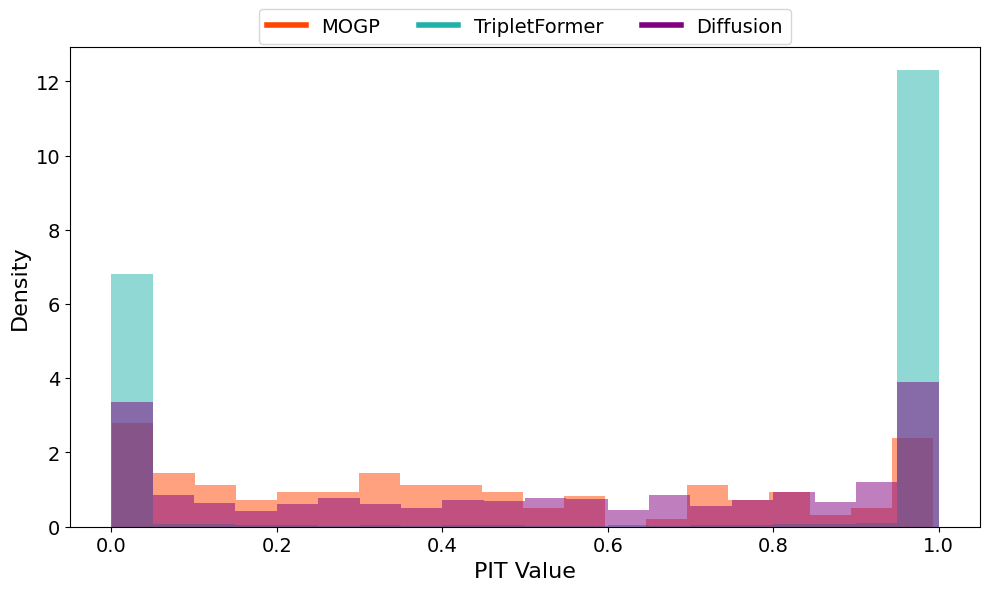

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
from matplotlib.lines import Line2D

# --- Model directories ---
model_dirs = {
    'MOGP': '../GPyTorch',
    'TripletFormer': '../Tripletformer',
    'Diffusion': '../Diffusion'
}

def normalize_pit_keys(model_name, data):
    """Normalize key names to the form pit_<band>."""
    normalized = {}
    for key in data.keys():
        if model_name == 'MOGP' and key.endswith('_pit'):
            band = key.replace('_pit', '')
            normalized[f'pit_{band}'] = data[key]
        elif model_name == 'TripletFormer' and key in ['X', 'NIR', 'IR', 'Sub-mm']:
            normalized[f'pit_{key}'] = data[key]
        elif model_name == 'Diffusion' and key.endswith('_pit_values'):
            band = key.replace('_pit_values', '')
            normalized[f'pit_{band}'] = data[key]
    return normalized

# --- Load PIT data ---
pit_data = {}
for model_name, path in model_dirs.items():
    pit_file = os.path.join(path, 'pit_values.npz')
    if not os.path.exists(pit_file):
        print(f"[Warning] PIT file not found for {model_name}: {pit_file}")
        continue

    data = np.load(pit_file)
    normalized = normalize_pit_keys(model_name, data)
    if not normalized:
        print(f"[Warning] No recognizable PIT arrays found for {model_name}. Keys: {list(data.keys())}")
        continue

    pit_data[model_name] = normalized
    print(f"[Loaded] {model_name}: {list(normalized.keys())}")

# --- Check ---
if not pit_data:
    raise RuntimeError("No valid PIT data found for any model!")

# --- Only IR band ---
band = 'IR'

# Color mapping
colors = {
    "MOGP": "#FF4500",
    "TripletFormer": "#20B2AA",
    "Diffusion": "#800080"
}

# Plot settings
plt.figure(figsize=(10, 6))

for model_name, model_pits in pit_data.items():
    key = f'pit_{band}'
    if key not in model_pits:
        continue
    pits = np.asarray(model_pits[key]).flatten()
    if len(pits) == 0:
        continue

    ks_stat, ks_pval = kstest(pits, 'uniform')
    plt.hist(
        pits,
        bins=20,
        alpha=0.5,
        density=True,
        color=colors.get(model_name, "gray"),
        label=f"{model_name} (p={ks_pval:.3f})"
    )

# Formatting like coverage plot
# plt.title(f"PIT Histogram - {band}", fontsize=18)
plt.xlabel("PIT Value", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.6)

# Custom legend
legend_handles = [
    Line2D([0], [0], color=colors[m], label=m, linewidth=4) for m in pit_data.keys()
]
plt.legend(handles=legend_handles, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.10), ncol=3)

plt.tight_layout()
plt.savefig('PIT_histogram_IR.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
from matplotlib.lines import Line2D

# --- Model directories ---
model_dirs = {
    'MOGP': '../GPyTorch',
    'TripletFormer': '../Tripletformer',
    'Diffusion': '../Diffusion'
}

def normalize_pit_keys(model_name, data):
    """Normalize key names to the form pit_<band>."""
    normalized = {}
    for key in data.keys():
        if model_name == 'MOGP' and key.endswith('_pit'):
            band = key.replace('_pit', '')
            normalized[f'pit_{band}'] = data[key]
        elif model_name == 'TripletFormer' and key in ['X', 'NIR', 'IR', 'Sub-mm']:
            normalized[f'pit_{key}'] = data[key]
        elif model_name == 'Diffusion' and key.endswith('_pit_values'):
            band = key.replace('_pit_values', '')
            normalized[f'pit_{band}'] = data[key]
    return normalized

# --- Load PIT data ---
pit_data = {}
for model_name, path in model_dirs.items():
    pit_file = os.path.join(path, 'pit_values.npz')
    if not os.path.exists(pit_file):
        print(f"[Warning] PIT file not found for {model_name}: {pit_file}")
        continue

    data = np.load(pit_file)
    normalized = normalize_pit_keys(model_name, data)
    if not normalized:
        print(f"[Warning] No recognizable PIT arrays found for {model_name}. Keys: {list(data.keys())}")
        continue

    pit_data[model_name] = normalized
    print(f"[Loaded] {model_name}: {list(normalized.keys())}")

# --- Check ---
if not pit_data:
    raise RuntimeError("No valid PIT data found for any model!")

# Bands to plot
bands = ['X', 'NIR', 'IR', 'Sub-mm']

# Color mapping
colors = {
    "MOGP": "#FF4500",
    "TripletFormer": "#20B2AA",
    "Diffusion": "#800080"
}

# --- Plot stacked histograms with no vertical spacing ---
fig, axes = plt.subplots(
    len(bands), 1, figsize=(10, 12), sharex=True,
    gridspec_kw={'hspace': 0}  # Remove space between subplots
)

for i, band in enumerate(bands):
    ax = axes[i]
    for model_name, model_pits in pit_data.items():
        key = f'pit_{band}'
        if key not in model_pits:
            continue
        pits = np.asarray(model_pits[key]).flatten()
        if len(pits) == 0:
            continue

        ks_stat, ks_pval = kstest(pits, 'uniform')
        ax.hist(
            pits,
            bins=20,
            alpha=0.5,
            density=True,
            color=colors.get(model_name, "gray"),
            label=f"{model_name} (p={ks_pval:.3f})"
        )

    ax.set_ylabel(f"{band}", fontsize=14)
    ax.tick_params(axis='y', labelsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)

    # Hide x-axis labels except for the bottom subplot
    if i < len(bands) - 1:
        ax.set_xticklabels([])

# Shared x-axis label at the bottom
axes[-1].set_xlabel("PIT Value", fontsize=14)

# Custom legend above the subplots
legend_handles = [Line2D([0], [0], color=colors[m], label=m, linewidth=4) for m in pit_data.keys()]
fig.legend(handles=legend_handles, fontsize=14, loc='upper center', ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('PIT_histograms_stacked_no_space.pdf', format='pdf', bbox_inches='tight')
plt.show()


# Coverage Plots

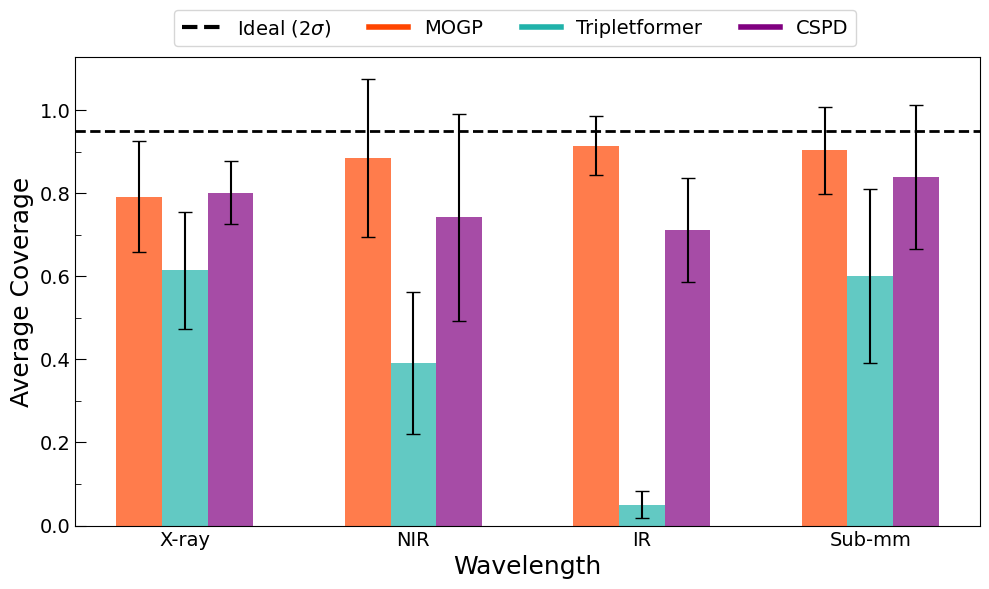

In [5]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
import glob

# Load data from seed files
all_seeds_coverage = {}
loaded_keys = None
for filename in glob.glob('coverage_plot_data_*.npz'):
    loaded_data = np.load(filename, allow_pickle=True)
    coverage_data = loaded_data['coverage_data'].item()
    keys = loaded_data['keys']

    if loaded_keys is None:
        loaded_keys = keys

    for model, coverage_values in coverage_data.items():
        if model not in all_seeds_coverage:
            all_seeds_coverage[model] = {key: [] for key in keys}
        for i, key in enumerate(keys):
            if len(coverage_values) > i:
                all_seeds_coverage[model][key].append(coverage_values[i])

# Calculate mean and std across seeds
coverage_stats = {
    model: {
        key: {
            "mean": np.nanmean(values),
            "std": np.nanstd(values, ddof=1)  # unbiased std
        }
        for key, values in wavelength_data.items()
    }
    for model, wavelength_data in all_seeds_coverage.items()
}

# Automatic model name mapping
name_map = {
    "mogp": "MOGP",
    "tripletformer": "Tripletformer",
    "cspd": "CSPD",
}
colors = {
    "mogp": "#FF4500",
    "tripletformer": "#20B2AA",
    "cspd": "#800080",
}

# Plot settings
model_names = list(coverage_stats.keys())
num_wavelengths = len(loaded_keys)
bar_width = 0.2
x = np.arange(num_wavelengths)

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with error bars
for i, model_name in enumerate(model_names):
    avg_coverage_values = [coverage_stats[model_name][key]["mean"] for key in loaded_keys]
    std_coverage_values = [coverage_stats[model_name][key]["std"] for key in loaded_keys]

    positions = x + (i * bar_width - bar_width)
    ax.bar(
        positions,
        avg_coverage_values,
        bar_width,
        color=colors.get(model_name.lower(), "gray"),
        alpha=0.7,
        yerr=std_coverage_values,
        capsize=5,
        ecolor="black"
    )

# Custom legend
legend_handles = [
    Line2D([0], [0], color='black', linestyle='--', label=r'Ideal (2$\sigma$)', linewidth=3)
]
for model_key, pretty_name in name_map.items():
    legend_handles.append(Line2D([0], [0], color=colors[model_key], label=pretty_name, linewidth=4))

fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.52, 1.02), ncol=4, fontsize=14)

# Ideal coverage line
ax.axhline(0.95, color='black', linestyle='--', linewidth=2)

# Axis labels and ticks
ax.set_ylabel("Average Coverage", fontsize=18)
ax.set_xlabel("Wavelength", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(['X-ray', 'NIR', 'IR', 'Sub-mm'], fontsize=14)

# Major and minor ticks on y-axis
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 11), minor=True)
ax.tick_params(axis='y', which='major', direction='in', length=8, labelsize=14)
ax.tick_params(axis='x', which='major', direction='in', length=0, labelsize=14)
ax.tick_params(axis='y', which='minor', direction='in', length=4, labelsize=0)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('coverage_histogram.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.lines import Line2D

# # Load the calibration data
# calibration_data = np.load('final_metrics.npz', allow_pickle=True)
# coverage_percentages = calibration_data['coverage_percentages']
# calibration_results = calibration_data['calibration'].item()
# colors = ['#FF4500', '#20B2AA', '#800080']

# # Plot calibration curvesimport numpy as np
# import glob
# import re
# from collections import defaultdict

# metric_files = glob.glob("metrics_*_seed_*.npz")

# results = defaultdict(list)
# coverage_percentages = None

# pattern = re.compile(r"metrics_(.+?)_seed_(\d+)\.npz")

# for f in metric_files:
#     match = pattern.search(f)
#     if not match:
#         continue
#     model_name = match.group(1)

#     data = np.load(f, allow_pickle=True)
#     calibration = data["calibration_per_percentage"]

#     results[model_name].append(calibration)
#     if coverage_percentages is None:
#         coverage_percentages = data["coverage_percentages"]

# # Compute mean ± std across seeds for each model
# calibration_mean = {}
# calibration_std = {}

# for model, calibs in results.items():
#     calibs = np.vstack(calibs)  # shape (n_seeds, n_coverages)
#     calibration_mean[model] = np.mean(calibs, axis=0)
#     calibration_std[model] = np.std(calibs, axis=0)

# # Save final aggregated metrics
# np.savez(
#     "final_metrics.npz",
#     coverage_percentages=coverage_percentages,
#     calibration=calibration_mean,
#     calibration_std=calibration_std
# )

# fig, ax = plt.subplots(figsize=(8, 6))

# for i, (model_name, coverage_values) in enumerate(calibration_results.items()):
#     ax.plot(coverage_percentages, coverage_values, color=colors[i], marker='o', linewidth=2, label=model_name)

# # Ideal calibration line
# ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal Calibration')

# # Major and minor ticks customization
# ax.set_xticks(np.linspace(0, 1, 6))
# ax.set_yticks(np.linspace(0, 1, 6))
# ax.set_xticks(np.linspace(0, 1, 11), minor=True)
# ax.set_yticks(np.linspace(0, 1, 11), minor=True)

# ax.tick_params(axis='both', which='major', direction='in', length=8, labelsize=14)
# ax.tick_params(axis='both', which='minor', direction='in', length=4, labelsize=0)

# ax.set_xlabel('Nominal Coverage Probability', fontsize=18)
# ax.set_ylabel('Empirical Coverage', fontsize=18)
# ax.grid(True, linestyle='--', which='both', alpha=0.7)

# # Custom legend
# legend_handles = [
#     Line2D([0], [0], color='black', label='Ideal', linestyle='dashed', linewidth=3),
#     Line2D([0], [0], marker='o', color=colors[0], label='MOGP', markersize=10, linewidth=4),
#     Line2D([0], [0], marker='o', color=colors[1], label='Tripletformer', markersize=10, linewidth=4),
#     Line2D([0], [0], marker='o', color=colors[2], label='CSPD', markersize=10, linewidth=4)
# ]
# ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4, fontsize=14)

# plt.tight_layout(rect=[0, 0.03, 1, 0.94])
# plt.savefig('coverage_line.pdf', format='pdf', bbox_inches='tight')

# plt.show()

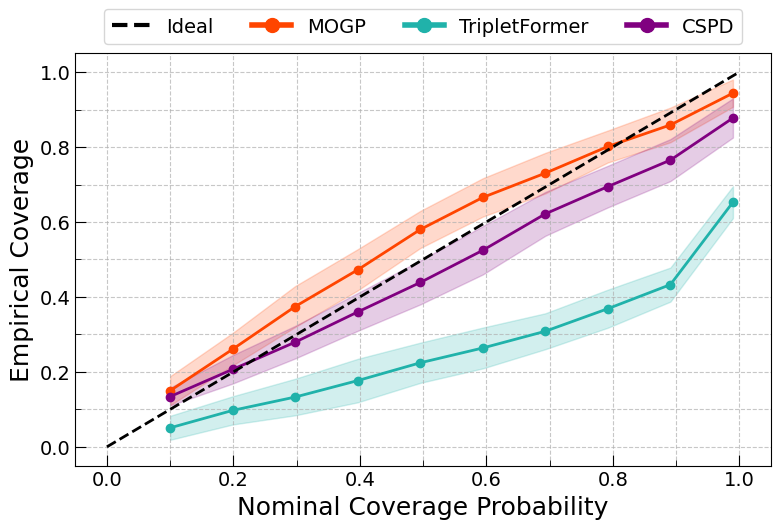

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Load the calibration data
calibration_data = np.load('final_metrics.npz', allow_pickle=True)
coverage_percentages = calibration_data['coverage_percentages']
calibration_results = calibration_data['calibration'].item()
calibration_std = calibration_data['calibration_std'].item()

# Explicit mapping from model names to colors/labels
model_styles = {
    'MOGP':        {'color': '#FF4500', 'label': 'MOGP'},
    'TripletFormer': {'color': '#20B2AA', 'label': 'TripletFormer'},
    'Diffusion':   {'color': '#800080', 'label': 'CSPD'},  # your CSPD
}

# Plot calibration curves with uncertainties
fig, ax = plt.subplots(figsize=(8, 6))

for model_name, stats in calibration_results.items():
    mean_vals = stats
    std_vals = calibration_std[model_name]

    style = model_styles[model_name]
    ax.plot(coverage_percentages, mean_vals,
            color=style['color'], marker='o', linewidth=2, label=style['label'])
    ax.fill_between(coverage_percentages,
                    mean_vals - std_vals,
                    mean_vals + std_vals,
                    color=style['color'], alpha=0.2)

# Ideal calibration line
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Ideal Calibration')

# Major and minor ticks customization
ax.set_xticks(np.linspace(0, 1, 6))
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xticks(np.linspace(0, 1, 11), minor=True)
ax.set_yticks(np.linspace(0, 1, 11), minor=True)

ax.tick_params(axis='both', which='major', direction='in', length=8, labelsize=14)
ax.tick_params(axis='both', which='minor', direction='in', length=4, labelsize=0)

ax.set_xlabel('Nominal Coverage Probability', fontsize=18)
ax.set_ylabel('Empirical Coverage', fontsize=18)
ax.grid(True, linestyle='--', which='both', alpha=0.7)

# Custom legend (automatically pulls from model_styles)
legend_handles = [
    Line2D([0], [0], color='black', label='Ideal', linestyle='dashed', linewidth=3)
]
for model_name, style in model_styles.items():
    legend_handles.append(Line2D([0], [0], marker='o', color=style['color'],
                                 label=style['label'], markersize=10, linewidth=4))

ax.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4, fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.savefig('coverage_line_with_uncertainties.pdf', format='pdf', bbox_inches='tight')
plt.show()
